In [51]:
import numpy as np
import networkx as nx
import seaborn as sns
from graspologic.plot import heatmap
import grakel
import hyppo
import matplotlib.pyplot as plt

# Exploring Different Kernels

Here we construct a basic pipeline of comparing different graph kernels from the [GraKel](https://ysig.github.io/GraKeL/0.1a8/) package. 

First, we load in 32 networks that were generated from MRI scans of mice brains, provided by [Graspologic](https://microsoft.github.io/graspologic/latest/index.html). The mice came from 4 different genotypes, and there were 8 mice per genotype. 

## Load Data

In [16]:
from graspologic.datasets import load_mice
from grakel import Graph

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

# initialize labels
labels = {}
for i in np.arange(0, 332):
    labels[i] = i

# Convert adjacency matrices to grakel objects
Gs = []
for graph in graphs:
    Gs.append(Graph(initialization_object = graph, node_labels=labels))
print(len(Gs))

(32, 332, 332)
32


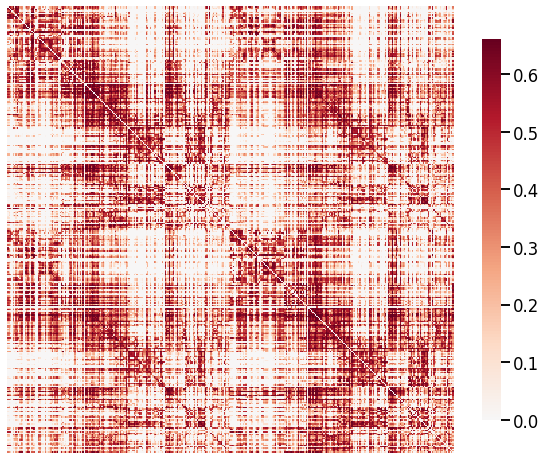

In [14]:
# Visualize one of the graphs
ax = heatmap(graph, context='talk', transform='simple-all')
ax.figure.set_facecolor('w')

## Global Kernels

The following kernels are constructed using characteristics of the entire graph. For each metric, the absolute differences between every pair of graphs were calculated and visualized using a heatmap.

### Density
The density of each graph was calculated by dividing the number of edges by the number of possible nodes.

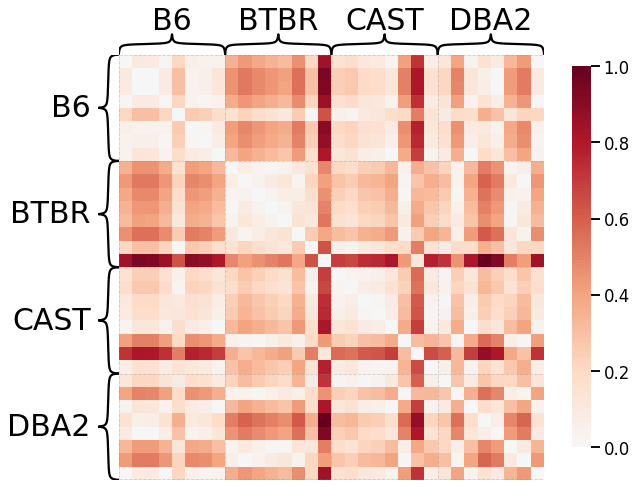

In [40]:
num_nodes = graphs.shape[1]
num_nodes_possible = num_nodes ** 2 - num_nodes

# calculate density of each graph
density = np.zeros(len(graphs))
for i in range(len(graphs)):
    num_edges = np.count_nonzero(graphs[i])
    density[i] = num_edges / num_nodes_possible

# calculate absolute difference of density 
density_dissim_matrix = np.zeros((len(graphs), len(graphs)))
for j in range(len(density)):
    for k in range(len(density)):
        diff = np.abs(density[j] - density[k])
        density_dissim_matrix[j, k] = diff

# plot heatmap
scaled_density_dissim = density_dissim_matrix / np.max(density_dissim_matrix)

ax = heatmap(scaled_density_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Average Edge Weight

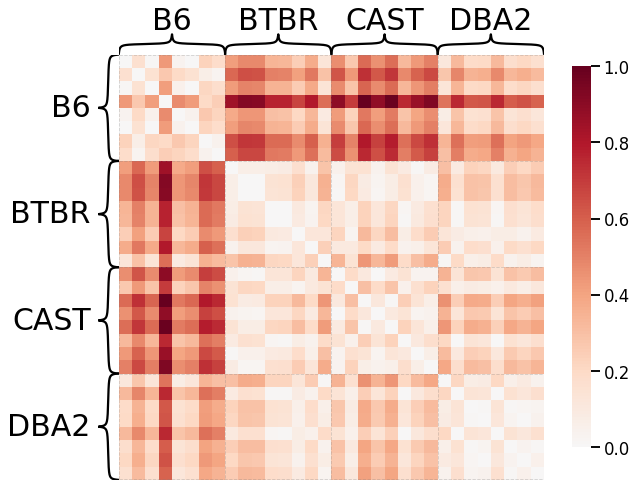

In [41]:
# calculate average edge weight
edgeweight_avg = np.zeros(len(graphs))
for i in range(len(graphs)):
    num_edges = np.count_nonzero(graphs[i])
    edgeweight_avg[i] = np.sum(graphs[i]) / num_edges

# calculate absolute difference 
avgedgeweight_matrix = np.zeros((len(graphs), len(graphs)))
for j in range(len(edgeweight_avg)):
    for k in range(len(edgeweight_avg)):
        diff = np.abs(edgeweight_avg[j] - edgeweight_avg[k])
        avgedgeweight_matrix[j, k] = diff

# plot heatmap
scaled_avgedgeweight_dissim = avgedgeweight_matrix / np.max(avgedgeweight_matrix)

ax = heatmap(scaled_avgedgeweight_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Average of the Adjacency Matrix
Note that when we calculate the average of each adjacency matrix, we include edges that do not exist, whereas we only consider those with nonzero values when we calculate the average edge weight of each graph.

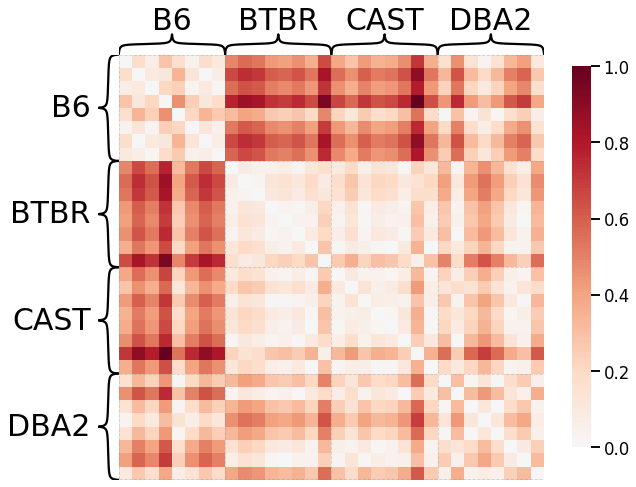

In [42]:
# calculate the average of each adjacency matrix
adjmat_avg = np.zeros(len(graphs))
for i in range(len(graphs)):
    adjmat_avg[i] = np.average(graphs[i])

# calculate absolute difference 
avgadjmat_matrix = np.zeros((len(graphs), len(graphs)))
for j in range(len(adjmat_avg)):
    for k in range(len(adjmat_avg)):
        diff = np.abs(adjmat_avg[j] - adjmat_avg[k])
        avgadjmat_matrix[j, k] = diff

# plot heatmap
scaled_avgadjmat_dissim = avgadjmat_matrix / np.max(avgadjmat_matrix)

ax = heatmap(scaled_avgadjmat_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Node-wise Kernels
The following kernels use characteristics related to the nodes of each graph. For each metric, we calculate a difference vector between every pair of graphs, then compute and visulize the L1 and L2 norms of the difference vector using a heatmap.

### Node Degrees - L1 Norm
The degree of a node in a graph is the number of nodes each node is adjacent to, aka the number of edges each node has.

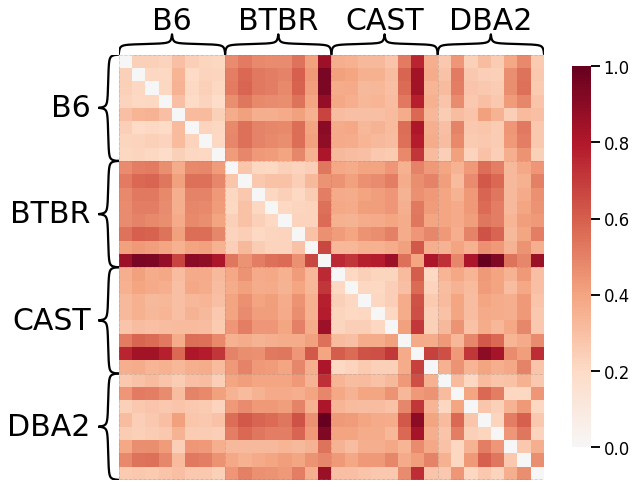

In [43]:
# find the degree of each node for each graph
degrees = np.zeros((graphs.shape[0], graphs.shape[1]))
for i, graph in enumerate(graphs):
    for j, row in enumerate(graph):
        degrees[i, j] = np.count_nonzero(row)

# construct difference vector and compute L1 norm
nodedeg_matrix_l1 = np.zeros((len(graphs), len(graphs)))
for i, degree1 in enumerate(degrees):
    for j, degree2 in enumerate(degrees):
        diff = np.linalg.norm((degree1 - degree2), ord=1)
        nodedeg_matrix_l1[i, j] = diff

# plot heatmap
scaled_nodedeg_dissim_l1 = nodedeg_matrix_l1 / np.max(nodedeg_matrix_l1)

ax = heatmap(scaled_nodedeg_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Degrees - L2 Norm

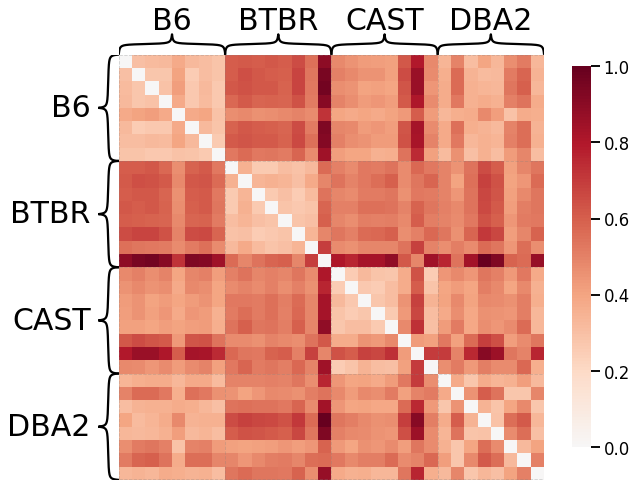

In [44]:
# find the degree of each node for each graph
degrees = np.zeros((graphs.shape[0], graphs.shape[1]))
for i, graph in enumerate(graphs):
    for j, row in enumerate(graph):
        degrees[i, j] = np.count_nonzero(row)
        
# find difference vector and compute L2 norm
nodedeg_matrix_l2 = np.zeros((len(graphs), len(graphs)))
for i, degree1 in enumerate(degrees):
    for j, degree2 in enumerate(degrees):
        diff = np.linalg.norm((degree1 - degree2), ord=2)
        nodedeg_matrix_l2[i, j] = diff

# plot heatmap
scaled_nodedeg_dissim_l2= nodedeg_matrix_l2 / np.max(nodedeg_matrix_l2)

ax = heatmap(scaled_nodedeg_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Strength - L1 Norm
Node strength, unlike node degree, takes into account the weight of the edges each node has. We calculate node strength by finding the sum of the edge weights for each node.

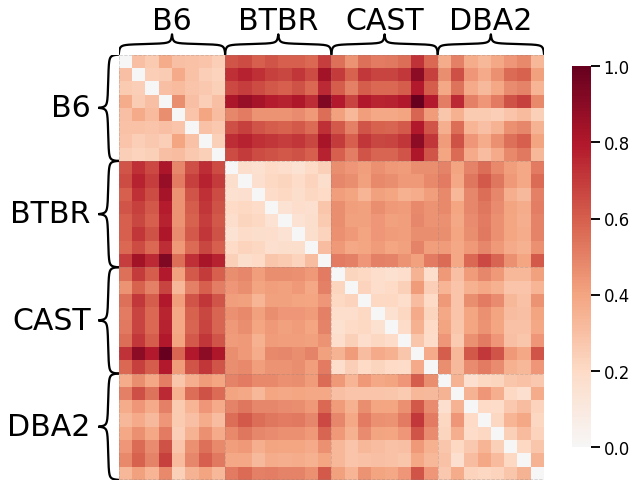

In [45]:
# compute the strength of each node for each graph
strengths = np.zeros((graphs.shape[0], graphs.shape[1]))
for i, graph in enumerate(graphs):
    for j, row in enumerate(graph):
        strengths[i, j] = np.sum(row)
        
# find difference vector and compute L1 norm
nodestr_matrix_l1 = np.zeros((len(graphs), len(graphs)))
for i, strength1 in enumerate(strengths):
    for j, strength2 in enumerate(strengths):
        diff = np.linalg.norm((strength1 - strength2), ord=1)
        nodestr_matrix_l1[i, j] = diff

# plot heatmap
scaled_nodestr_dissim_l1 = nodestr_matrix_l1 / np.max(nodestr_matrix_l1)

ax = heatmap(scaled_nodestr_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Node Strength - L2 Norm

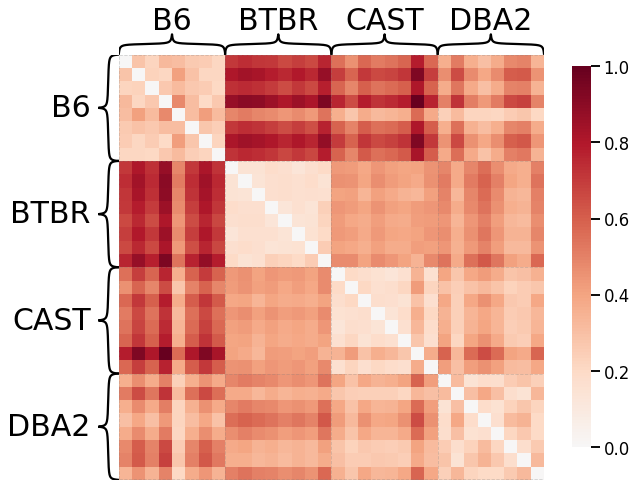

In [46]:
# compute the strength of each node for each graph
strengths = np.zeros((graphs.shape[0], graphs.shape[1]))
for i, graph in enumerate(graphs):
    for j, row in enumerate(graph):
        strengths[i, j] = np.sum(row)
        
# find difference vector and compute L2 norm
nodestr_matrix_l2 = np.zeros((len(graphs), len(graphs)))
for i, strength1 in enumerate(strengths):
    for j, strength2 in enumerate(strengths):
        diff = np.linalg.norm(strength1 - strength2, ord=2)
        nodestr_matrix_l2[i, j] = diff

# plot heatmap
scaled_nodestr_dissim_l2 = nodestr_matrix_l2 / np.max(nodestr_matrix_l2)

ax = heatmap(scaled_nodestr_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Edge-wise Kernels
The following kernels use characteristics related to the edges of each graph. For each metric, we calculate a difference vector between every pair of graphs, then compute and visulize the L1 and L2 norms of the difference vector using a heatmap.

### Edge weights - L1 Norm
Here we compare the weights of each edge between graphs by simply subtracting one adjacency matrix from another.

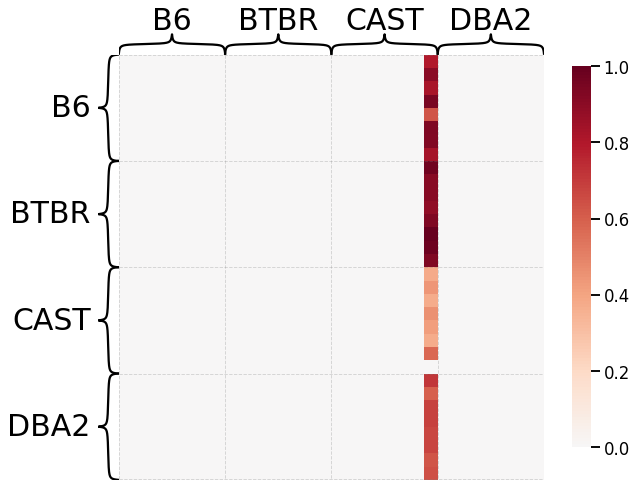

In [47]:
# find difference between two adjacency matrices and compute L1 norm
edgeweight_matrix_l1 = np.zeros((len(graphs), len(graphs)))
for i in range(len(graphs)):
    for j in range(len(graphs)):
        diff = np.linalg.norm(graphs[i] - graphs[j], ord=1)
        edgeweight_matrix_l1[j, k] = diff

# plot heatmap
scaled_edgeweight_dissim_l1 = edgeweight_matrix_l1 / np.max(edgeweight_matrix_l1)

ax = heatmap(scaled_edgeweight_dissim_l1, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### Edge Weights - L2 Norm

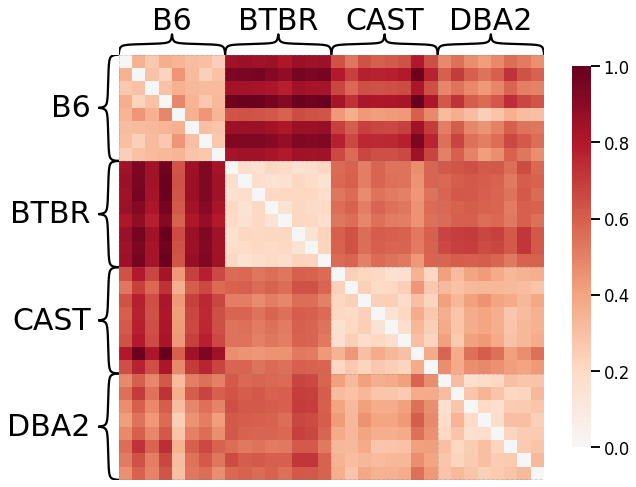

In [48]:
# find difference between two adjacency matrices and compute L1 norm
edgeweight_matrix_l2 = np.zeros((len(graphs), len(graphs)))
for i in range(len(graphs)):
    for j in range(len(graphs)):
        diff = np.linalg.norm((graphs[i] - graphs[j]), ord=2)
        edgeweight_matrix_l2[i, j] = diff

# plot heatmap
scaled_edgeweight_dissim_l2 = edgeweight_matrix_l2 / np.max(edgeweight_matrix_l2)

ax = heatmap(scaled_edgeweight_dissim_l2, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Using Kernels from GraKel

(32, 32)


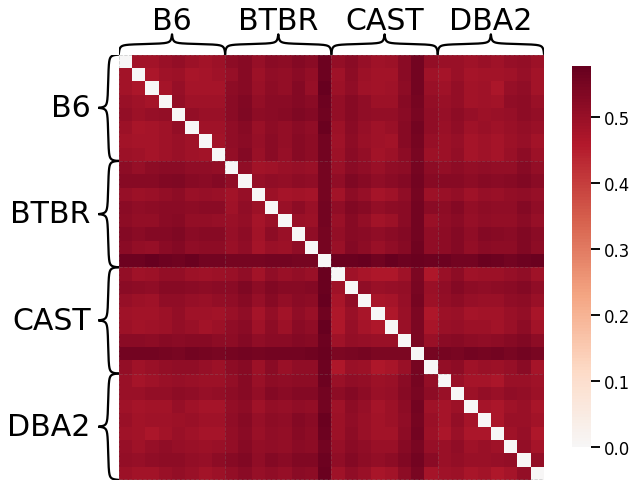

In [31]:
### Shortest Path 
from grakel.kernels import ShortestPath

kernel = ShortestPath(with_labels=True)
Ks = kernel.fit_transform(Gs)

print(Ks.shape)

scaled_dissimilarity = Ks / np.max(Ks)
scaled_dissimilarity = 1 - scaled_dissimilarity

ax = heatmap(scaled_dissimilarity, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

(32, 32)


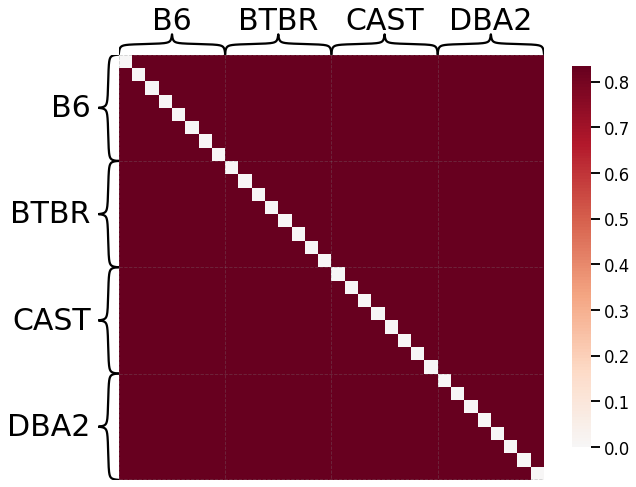

In [32]:
from grakel.kernels import WeisfeilerLehman, VertexHistogram

kernel = WeisfeilerLehman(base_graph_kernel=VertexHistogram, normalize=False)
Ks = kernel.fit_transform(Gs)
print(Ks.shape)

scaled_dissimilarity = Ks / np.max(Ks)
scaled_dissimilarity = 1 - scaled_dissimilarity

ax = heatmap(scaled_dissimilarity, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

### From Ben's NDS class [Network Data Science](https://bdpedigo.github.io/networks-course/multiple_embedding.html#representations-for-each-network)

In [49]:
from graspologic.embed import OmnibusEmbed

# Embed using Omni
embedder = OmnibusEmbed(n_elbows=3)
omni_embedding = embedder.fit_transform(graphs)
print(omni_embedding.shape)

(32, 332, 9)


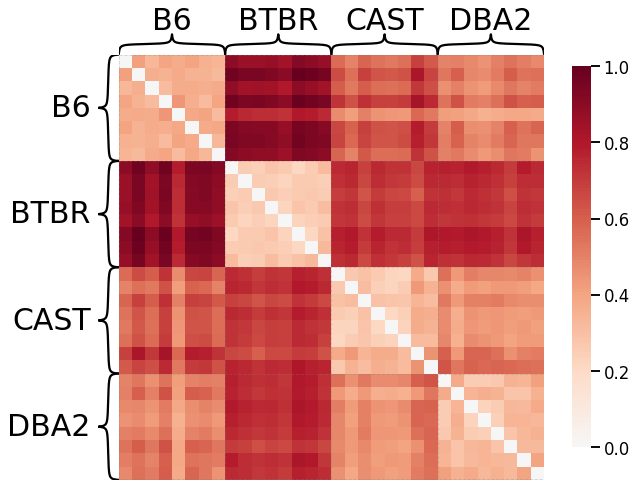

In [50]:
# create dissimilarity matrix
omni_matrix = np.zeros((len(graphs), len(graphs)))
for i, embedding1 in enumerate(omni_embedding):
    for j, embedding2 in enumerate(omni_embedding):
        dist = np.linalg.norm(embedding1 - embedding2, ord="fro")
        omni_matrix[i, j] = dist

# plot heatmap
scaled_omni_dissim = omni_matrix / np.max(omni_matrix)

ax = heatmap(scaled_omni_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

## Discriminability Plot

In [79]:
control_matrix = np.zeros((len(graphs), len(graphs)))

for i, graph1 in enumerate(graphs):
    for j, graph2 in enumerate(graphs):
        dist = np.linalg.norm(graph1 - graph2, ord="fro")
        control_matrix[i, j] = dist

scaled_control_dissim = control_matrix / np.max(control_matrix)
test = np.column_stack((np.ravel(scaled_density_dissim), np.ravel(scaled_density_dissim)))
print(np.shape(test))
print(np.shape(np.ravel(scaled_control_dissim)))

from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()
test_stat, p = discrim.test(test, np.ravel(scaled_control_dissim))
print(test_stat)
test_stat2 = DiscrimOneSample(is_dist=True).statistic(scaled_density_dissim, scaled_control_dissim)
print(test_stat2)

(1024, 2)
(1024,)
0.999974354523073


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [59]:
control_matrix = np.zeros((len(graphs), len(graphs)))

for i, graph1 in enumerate(graphs):
    for j, graph2 in enumerate(graphs):
        dist = np.linalg.norm(graph1 - graph2, ord="fro")
        control_matrix[i, j] = dist

scaled_control_dissim = control_matrix / np.max(control_matrix)

from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample(is_dist=True)

discrim_omni = discrim.statistic(scaled_omni_dissim, scaled_control_dissim)
discrim_density = discrim.statistic(scaled_control_dissim, scaled_density_dissim)
discrim_avgedgeweight = discrim.statistic(scaled_control_dissim, scaled_avgedgeweight_dissim)
discrim_avgadjmat = discrim.statistic(scaled_control_dissim, scaled_avgadjmat_dissim)
discrim_nodedeg_l1 = discrim.statistic(scaled_control_dissim, scaled_nodedeg_dissim_l1)
discrim_nodedeg_l2 = discrim.statistic(scaled_control_dissim, scaled_nodedeg_dissim_l2)
discrim_nodestr_l1 = discrim.statistic(scaled_control_dissim, scaled_nodestr_dissim_l1)
discrim_nodestr_l2 = discrim.statistic(scaled_control_dissim, scaled_nodestr_dissim_l2)
discrim_edgeweight_l1 = discrim.statistic(scaled_control_dissim, scaled_edgeweight_dissim_l1)
discrim_edgeweight_l2 = discrim.statistic(scaled_control_dissim, scaled_edgeweight_dissim_l2)

kernels = ['Omni', 'Density', 'Avg. Edge Weight', 'Avg. Adjacency', 'Node Degree (L1)', 'Node Degree (L2)', 'Node Strength (L1)', \
    'Node Strength (L2)', 'Edge Weight (L1)', 'Edge Weight (L2)']
stats = [discrim_omni, discrim_density, discrim_avgedgeweight, discrim_avgadjmat, discrim_nodedeg_l1, discrim_nodedeg_l2, \
    discrim_nodestr_l1, discrim_nodestr_l2, discrim_edgeweight_l1, discrim_edgeweight_l2]

plt.bar(kernels, stats)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed